couldn't import doomish
Couldn't import doom
(288, 512, 3)
(288, 512)


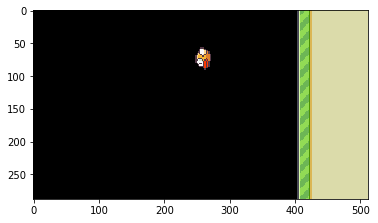

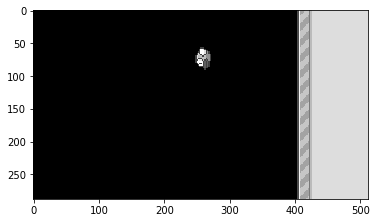

In [1]:
# import package needed
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy" # make window not appear
import tensorflow as tf
import numpy as np
import math
import skimage.color
import skimage.transform
from ple.games.flappybird import FlappyBird
from ple import PLE
from myUtil import make_anim
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False) # environment interface to game
env.reset_game()
env.act(0) # dummy input to get screen correct

# get rgb screen
screen = env.getScreenRGB()
plt.imshow(screen)
print(screen.shape)

# get grayscale screen
plt.figure()
screen = env.getScreenGrayscale()
plt.imshow(screen, cmap='gray')
print(screen.shape)

In [2]:
# define input size
screen_width = 80
screen_height = 80
num_stack = 4
def preprocess(screen):
    #screen = skimage.color.rgb2gray(screen)
    screen = skimage.transform.resize(screen, [screen_width, screen_height])
    return screen

In [3]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 10e-4


class Agent:
    def __init__(self, name, num_action, t=0, discount_factor=0.99):
        self.exploring_rate = 0.1
        self.discount_factor = discount_factor
        self.num_action = num_action
        self.name = name
        with tf.variable_scope(name):
            self.build_model()
            
        self.ckpt_path = './checkpoints/dualing_DQN'
        if not os.path.exists(self.ckpt_path):
            os.makedirs(self.ckpt_path)

        self.vars_to_save = [
            var for var in tf.trainable_variables() if name in var.name
        ]
        self.saver = tf.train.Saver(var_list=self.vars_to_save, max_to_keep=30)
    def build_model(self):
        # input: current screen, selected action and reward
        self.input_screen = tf.placeholder(
            tf.float32, shape=[None, screen_width, screen_height, num_stack])
        self.action = tf.placeholder(tf.int32, [None])
        self.reward = tf.placeholder(tf.float32, [None])
        self.is_training = tf.placeholder(tf.bool, shape=[])

        def net(screen, reuse=False):
            with tf.variable_scope(
                    "layers",
                    reuse=reuse,
                    initializer=tf.truncated_normal_initializer(stddev=1e-2)):
                conv1 = tf.layers.conv2d(
                    inputs=screen,
                    filters=32,
                    kernel_size=[8, 8],
                    strides=[4, 4],
                    padding='SAME',
                    activation=tf.nn.relu)
                pool1 = tf.layers.max_pooling2d(
                    conv1, pool_size=[2, 2], strides=[2, 2], padding='SAME')

                conv2 = tf.layers.conv2d(
                    inputs=pool1,
                    filters=64,
                    kernel_size=[4, 4],
                    strides=[2, 2],
                    padding='SAME',
                    activation=tf.nn.relu)
                conv3 = tf.layers.conv2d(
                    inputs=conv2,
                    filters=64,
                    kernel_size=[3, 3],
                    strides=[1, 1],
                    padding='SAME',
                    activation=tf.nn.relu)
                flat = tf.contrib.layers.flatten(conv3)
                
                # advantage estimation
                advantage_net = tf.layers.dense(
                    inputs=flat, units=512, activation=tf.nn.relu
                )
                advantage_estimate = tf.layers.dense(
                    inputs=advantage_net,
                    units=self.num_action
                )
                
                # V estimation
                V_net = tf.layers.dense(
                    inputs=flat, units=512, activation=tf.nn.relu
                )
                V_estimate = tf.layers.dense(
                    inputs=V_net,
                    units=1
                )
                
                # combine V(s) and advantage(s, a) to get Q(s, a)
                Q = V_estimate + tf.subtract(
                    advantage_estimate,
                    tf.reduce_mean(
                        advantage_estimate,
                        axis=1,
                        keep_dims=True
                    )
                )

                return Q

        # optimize
        self.output = net(
            self.input_screen
        )  # Q(s,a,theta) for all a, shape (batch_size, num_action)
        index = tf.stack(
            [tf.range(tf.shape(self.action)[0]), self.action], axis=1)
        self.esti_Q = tf.gather_nd(
            self.output,
            index)  # Q(s,a,theta) for selected action, shape (batch_size, 1)

        self.max_Q = tf.reduce_max(
            self.output, axis=1)  # max(Q(s',a',theta')), shape (batch_size, 1)
        self.tar_Q = tf.placeholder(tf.float32, [None])

        # loss = E[r+max(Q(s',a',theta'))-Q(s,a,theta)]
        self.loss = tf.reduce_mean(
            tf.square(self.reward + self.discount_factor * self.tar_Q -
                      self.esti_Q))

        optimizer = tf.train.AdamOptimizer(learning_rate=1e-5)
        self.g_gvs = optimizer.compute_gradients(
            self.loss,
            var_list=[v for v in tf.global_variables() if self.name in v.name])
        self.train_op = optimizer.apply_gradients(self.g_gvs)
        self.pred = tf.argmax(
            self.output, axis=1
        )  # select action with highest action-value, only used in inference

    def select_action(self, input_screen, sess):
        # epsilon-greedy
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            input_screen = np.array(input_screen).transpose([1, 2, 0])
            feed_dict = {
                self.input_screen: input_screen[None, :],
                self.is_training: False,
            }
            action = sess.run(
                self.pred,
                feed_dict=feed_dict)[0]  # Select the action with the highest q
        return action

    def update_policy(self, input_screens, actions, rewards,
                      input_screens_plum, terminal, target_netwrok):
        # use max_Q estimate from target one to update online one
        feed_dict = {
            target_netwrok.input_screen:
            np.array(input_screens_plum).transpose([0, 2, 3, 1]),
            target_netwrok.is_training:
            True,
        }
        max_Q = sess.run(target_netwrok.max_Q, feed_dict=feed_dict)
        max_Q *= ~np.array(terminal)
        feed_dict = {
            self.input_screen: np.array(input_screens).transpose([0, 2, 3, 1]),
            self.tar_Q: max_Q,
            self.action: actions,
            self.reward: rewards,
            self.is_training: True,
        }
        loss, _ = sess.run([self.loss, self.train_op], feed_dict=feed_dict)
        return loss

    def update_parameters(self, episode):
        if self.exploring_rate > MIN_EXPLORING_RATE:
            self.exploring_rate -= (0.1 - MIN_EXPLORING_RATE) / 3000000

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0
        
    def preprocess(self, screen):
        #screen = skimage.color.rgb2gray(screen)
        screen = skimage.transform.resize(screen, [screen_width, screen_height])
        return screen
    
    def _get_ckpt_name(self, episode):
        return os.path.join(self.ckpt_path, '%s_epidode_%d' % (self.name, episode))
    
    def save_ckpt(self, sess, episode):
        print('Saving variables of %s agent(%d episode)...' % (self.name, episode), end='')
        self.saver.save(sess, self._get_ckpt_name(episode))
        print('Done.')
    
    def load_ckpt(self, sess, episode):
        print('Loading variables of %s agent(%d episode)...' % (self.name, episode), end='')
        self.saver.restore(sess, self._get_ckpt_name(episode))
        print('Done.')

In [4]:
def get_update_ops():
    # return operations assign weight to target network
    src_vars = [v for v in tf.global_variables() if 'online' in v.name]
    tar_vars = [v for v in tf.global_variables() if 'target' in v.name]
    update_ops = []
    for src_var, tar_var in zip(src_vars, tar_vars):
        update_ops.append(tar_var.assign(src_var))
    return update_ops


def update_target(update_ops, sess):
    sess.run(update_ops)

In [5]:
# init agent
tf.reset_default_graph()
num_action = len(env.getActionSet())

# agent for frequently updating
online_agent = Agent('online', num_action)

# agent for slow updating
target_agent = Agent('target', num_action)
update_ops = get_update_ops()

In [6]:
class Replay_buffer():
    def __init__(self, buffer_size=50000):
        self.experiences = []
        self.buffer_size = buffer_size

    def add(self, experience):
        if len(self.experiences) >= self.buffer_size:
            self.experiences.pop(0)
        self.experiences.append(experience)

    def sample(self, size):
        """
        sameple experience from buffer
        """
        if size > len(self.experiences):
            experiences_idx = np.random.choice(
                len(self.experiences), size=size)
        else:
            experiences_idx = np.random.choice(
                len(self.experiences), size=size, replace=False)
        # from all sampled experiences, extract a tuple of (s,a,r,s')
        screens = []
        actions = []
        rewards = []
        screens_plum = []
        terminal = []
        for i in range(size):
            screens.append(self.experiences[experiences_idx[i]][0])
            actions.append(self.experiences[experiences_idx[i]][1])
            rewards.append(self.experiences[experiences_idx[i]][2])
            screens_plum.append(self.experiences[experiences_idx[i]][3])
            terminal.append(self.experiences[experiences_idx[i]][4])
        return screens, actions, rewards, screens_plum, terminal


In [ ]:
# init all
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [ ]:
from IPython.display import Image, display

update_every_t_step = 6
print_every_episode = 10
save_video_every_episode = 200
ckpt_every = 400
NUM_EPISODE = 100000
NUM_EXPLORE = 1000

# we can redefine origin reward function
reward_values = {
    "positive": 1,  # reward pass a pipe
    "tick": 0.1,  # reward per timestamp
    "loss": -1,  # reward of gameover
}

# init buffer
buffer = Replay_buffer()
game = FlappyBird()
env = PLE(
    game,
    fps=30,
    display_screen=False,
    reward_values=reward_values,
    rng=np.random.RandomState(1))

restore_epoch = 600
if restore_epoch > 0:
    online_agent.load_ckpt(sess, restore_epoch)
    update_target(update_ops, sess)

best_t = 0
for episode in range(restore_epoch, restore_epoch + NUM_EPISODE + 1):
    # Reset the environment
    env.reset_game()
    env.act(0)  # dummy input to make sure input screen is correct

    # record frame
    if episode % save_video_every_episode == 0:
        frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        online_agent.shutdown_explore()

    # grayscale input screen for this episode
    input_screens = [preprocess(env.getScreenGrayscale())] * 4

    # experience for this episode, store all (s,a,r,s') tuple
    experience = []

    # cumulate reward for this episode
    cum_reward = 0

    t = 0
    while not env.game_over():

        # feed four previous screen, select an action
        action = online_agent.select_action(input_screens[-4:], sess)

        # execute the action and get reward
        reward = env.act(env.getActionSet()[action])

        # record frame
        if episode % save_video_every_episode == 0:
            frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # append grayscale screen for this episode
        input_screens.append(preprocess(env.getScreenGrayscale()))

        # append experience for this episode
        buffer.add((input_screens[-5:-1], action, reward, input_screens[-4:],
                    env.game_over()))
        t += 1

        # update agent
    if t > best_t:
        best_t = t
        print("Best t so far: %d" % t)
        
    if episode > NUM_EXPLORE:
        train_screens, train_actions,\
        train_rewards, train_screens_plum, terminal = buffer.sample(32)
        loss = online_agent.update_policy(train_screens, train_actions,
                                          train_rewards, train_screens_plum,
                                          terminal, target_agent)
    if t % update_every_t_step == 0 and episode > NUM_EXPLORE:
        update_target(update_ops, sess)

    # update explore rating and learning rate
    online_agent.update_parameters(episode)
    target_agent.update_parameters(episode)

    if episode % print_every_episode == 0 and episode > NUM_EXPLORE:
        print(
            "[{}] time live:{}, cumulated reward: {}, exploring rate: {}, loss: {}".
            format(episode, t, cum_reward, target_agent.exploring_rate, loss))

    if episode % save_video_every_episode == 0:  # for every 100 episode, record an animation
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie/DQN-{}.webm".format(episode), fps=60)
    
    if episode % ckpt_every == 0 and episode > NUM_EXPLORE:
        online_agent.save_ckpt(sess, episode)

print(type(input_screens))

Loading variables of online agent(600 episode)...INFO:tensorflow:Restoring parameters from ./checkpoints/dualing_DQN/online_epidode_600
Done.


/home/liu/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Best t so far: 61
[600] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999996700000001, loss: 0.009607061743736267
[MoviePy] >>>> Building video movie/DQN-600.webm
[MoviePy] Writing video movie/DQN-600.webm


100%|██████████| 63/63 [00:01<00:00, 57.46it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie/DQN-600.webm 



Saving variables of online agent(600 episode)...Done.
[610] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999963700000004, loss: 0.0032805860973894596
[620] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999930700000008, loss: 0.0003085833159275353
[630] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999897700000011, loss: 0.02977578528225422
[640] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999864700000015, loss: 0.0002856984210666269
[650] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999831700000018, loss: 0.02808445878326893
[660] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999798700000022, loss: 0.00019146938575431705
[670] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999765700000025, loss: 0.00017615324759390205
[680] time live:61, cumulated reward: 5.099999999999994, exploring rate: 0.09999732700000029, 